In [133]:
import pandas as pd
import os
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

from scipy.special import softmax
import theano.tensor as tt
import pytensor.tensor as pt

In [2]:
folder = '/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/raw_data'

filelist = [file for file in os.listdir(folder) if file.startswith('dataland')]
for file in filelist:
    exec("%s = pd.read_csv('%s')" % (file.split('.')[0], os.path.join(folder,file)))

In [3]:
# Data processing

dataland_economic_data_1984_2023['year'] = pd.DatetimeIndex(dataland_economic_data_1984_2023['date']).year
dataland_economic_data_1984_2023_collapsed = dataland_economic_data_1984_2023.drop('date', axis=1).groupby('year').mean().reset_index()
struct_df = dataland_election_results_1984_2023.merge(dataland_demographics, on=['province', 'region']).merge(dataland_economic_data_1984_2023_collapsed, on='year')
struct_df.head(2)

,year,province,region,party_in_power,provincial_winner,national_winner,national_pop_vote_winner,cc_share,dgm_share,pdal_share,ssp_share,population,python_pop_share,cobolite_pop_share,javarian_pop_share,electoral_college_votes,year_on_year_gdp_pct_change,unemployment_rate,year_on_year_inflation,year_on_year_stock_mkt_pct_change
0,1984,Amperville,Circuit Confederation,pdal,pdal,pdal,pdal,0.047924,0.181743,0.770333,0.0,1000000,0.765173,0.084048,0.150780,15,0.036,0.048,0.0615,0.20275
1,1984,Binaryshire,Metaflux Realm,pdal,cc,pdal,pdal,0.829564,0.022409,0.148026,0.0,150000,0.030380,0.927361,0.042259,7,0.036,0.048,0.0615,0.20275


In [4]:
indep = ['unemployment_rate', 'year_on_year_gdp_pct_change', 'year_on_year_inflation', 'year_on_year_stock_mkt_pct_change', 'python_pop_share', 'cobolite_pop_share', 'javarian_pop_share']
dep = 'vote_share'
level = 'year' # election year

In [5]:
# struct_df_melt = struct_df.melt(id_vars=['year', 'province', 'region']+indep, 
#                                 value_vars=['cc_share', 'dgm_share', 'pdal_share', 'ssp_share'] , 
#                                 var_name='party', 
#                                 value_name='vote_share')

In [188]:
struct_df.province.unique()

array(['Amperville', 'Binaryshire', 'Byteforge Domain', 'Cerebrica',
       'Circuiton', 'Cortexia', 'Electropolis', 'Infinitron Peninsula',
       'Infoglen', 'Neuronia', 'Quantumridge', 'Voltagea'], dtype=object)

In [220]:
df = struct_df[struct_df['province'] == 'Amperville'].copy()

indep = ['unemployment_rate', 'year_on_year_gdp_pct_change', 'year_on_year_inflation', 'year_on_year_stock_mkt_pct_change', 'python_pop_share', 'cobolite_pop_share', 'javarian_pop_share']
dep = ['cc_share', 'dgm_share', 'pdal_share', 'ssp_share']
level = ['year'] # election year

df_indep = df[indep]
df_dep =  df[dep] + 0.01 # add 0.01 to account for 0s in the party vote shares; otherwise model doesn't run
df_level =  df[level]

election_idx, election = df.year.factorize(sort=True)

coords = {
    "dep": df_dep.columns,
    "sample": np.arange(len(df_dep)),
    "indep": df_indep.columns,
    "election": election,
}

In [221]:
with pm.Model(coords=coords) as structural_model:
    # data inputs
    ivs = pm.Data('ivs', df_indep.values, dims=('sample', 'indep')) # NxK
    dv = pm.Data('dv', df_dep.values, dims=('sample', 'dep')) # Nx1

    # exp theta 
    theta = pm.Normal('theta', 0, 1)
    # scaling factor to adjust probabilities
    exptheta = pm.Deterministic('exptheta', pm.math.exp(theta))

    # hyperpriors
    # b0_mu = pm.Normal('b0_mu', 0, 1)
    # b0_mu = pm.HalfCauchy('b0_sigma', 1.0)

    # varying intercept by election year
    b0 = pm.Normal('b0', 0, 1, dims=('election', 'dep')) # Nx1

    b = pm.Gamma('b', 1, 0.5, dims=('indep', 'dep')) # 1xK
    # sigma_b = pm.HalfNormal('sigma_b', 0.1, dims=('indep', 'dep'))#pm.Normal('sigma_b', 0, 1, dims=('indep'))

    # a = pm.Deterministic('a', pm.math.exp(b0+ pm.math.dot(ivs, b))) # results in Nx1
    a = pm.Deterministic('a', pm.math.invlogit(b0[election_idx]+pm.math.dot(ivs, b))*exptheta) # results in Nx1

    # Dirichlet likelihood to model the observed dependent variables
    lik = pm.Dirichlet('likelihood', a=a, observed=dv, dims=('sample', 'dep'))

    # # perform inference using the data  
    trace = pm.sample(draws=1000, tune=100, chains=2, random_seed=42)  

    # # sampling data from before and after data is available  
    prior_pred = pm.sample_prior_predictive()  
    post_pred = pm.sample_posterior_predictive(trace) 

/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, b0, theta]


/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8863019228686428, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'exptheta'}>,
        <Axes: title={'center': 'exptheta'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

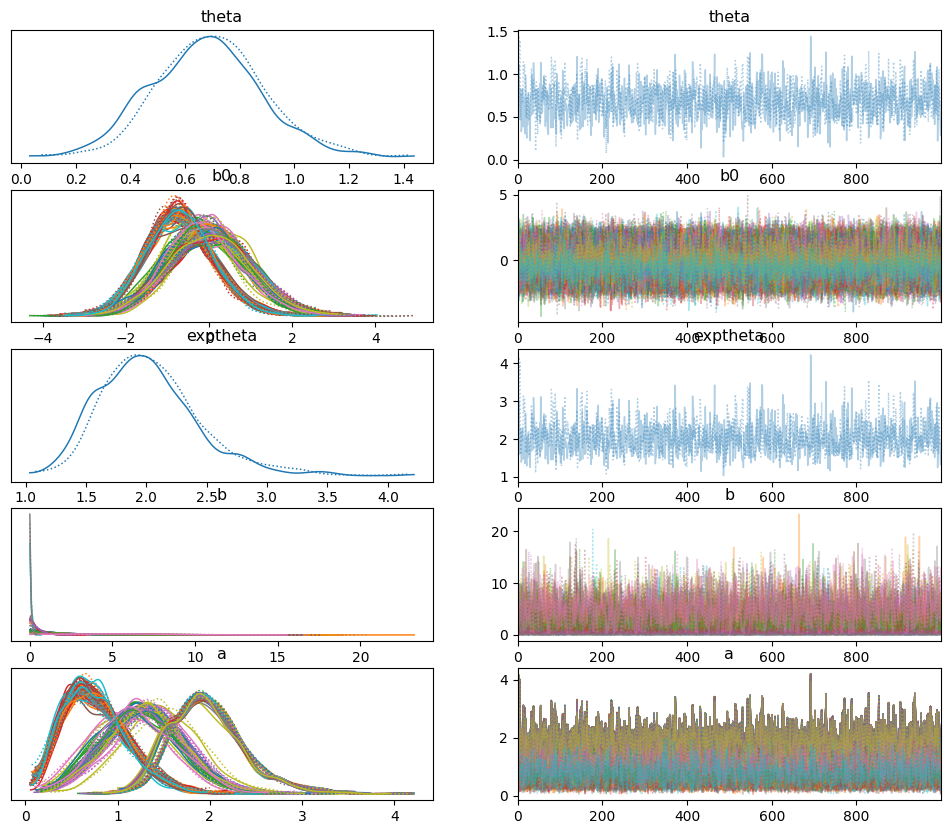

In [191]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'exptheta'}>,
        <Axes: title={'center': 'exptheta'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

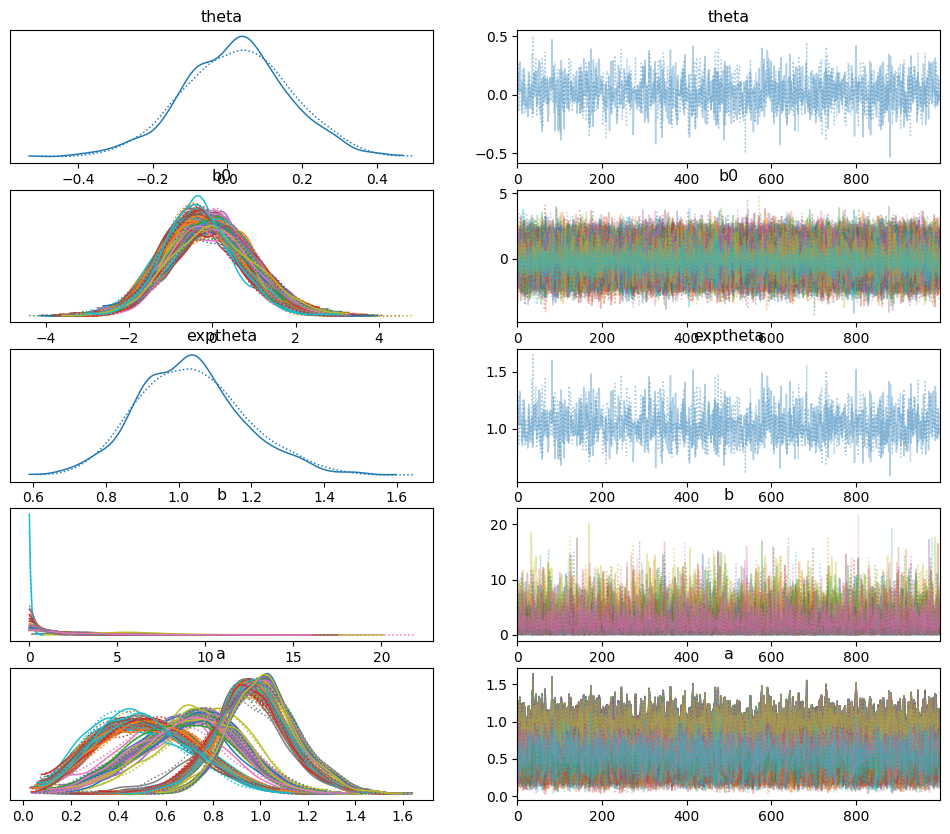

In [222]:
az.plot_trace(trace)

In [165]:
structural_model.basic_RVs

[theta ~ Normal,
 b0 ~ Normal,
 b_log__ ~ TransformedDistribution,
 likelihood ~ Dirichlet]

In [127]:
prior_pred['likelihood'].shape

(500, 480, 4)

In [192]:
az.summary(trace, var_names=['b0', 'b'])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b0[1984, cc_share]",-0.153,0.962,-1.821,1.817,0.015,0.024,4398.0,1398.0,1.0
"b0[1984, dgm_share]",0.036,0.972,-1.737,1.893,0.016,0.025,3814.0,1377.0,1.0
"b0[1984, pdal_share]",0.012,1.023,-1.813,1.918,0.016,0.025,3996.0,1438.0,1.0
"b0[1984, ssp_share]",-0.714,0.824,-2.327,0.829,0.016,0.014,2849.0,1209.0,1.0
"b0[1985, cc_share]",-0.068,0.960,-1.902,1.641,0.018,0.024,2728.0,1319.0,1.0
...,...,...,...,...,...,...,...,...,...
"b[cobolite_pop_share, ssp_share]",0.472,0.471,0.000,1.315,0.009,0.008,2284.0,1014.0,1.0
"b[javarian_pop_share, cc_share]",0.430,0.422,0.000,1.189,0.008,0.006,1999.0,1127.0,1.0
"b[javarian_pop_share, dgm_share]",5.203,3.028,0.021,10.213,0.075,0.053,1471.0,923.0,1.0
"b[javarian_pop_share, pdal_share]",5.173,2.971,0.011,10.095,0.078,0.055,1296.0,808.0,1.0


In [223]:
az.summary(trace, var_names=['b0', 'b'])

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b0[1984, cc_share]",-0.073,0.998,-1.878,1.762,0.014,0.027,5021.0,1231.0,1.0
"b0[1984, dgm_share]",0.025,1.026,-1.920,1.844,0.014,0.027,5351.0,1396.0,1.0
"b0[1984, pdal_share]",0.036,0.990,-1.568,2.102,0.015,0.027,4633.0,1366.0,1.0
"b0[1984, ssp_share]",-0.331,0.899,-2.006,1.312,0.013,0.024,4847.0,1274.0,1.0
"b0[1985, cc_share]",-0.055,0.967,-1.768,1.872,0.014,0.026,4770.0,1365.0,1.0
...,...,...,...,...,...,...,...,...,...
"b[cobolite_pop_share, ssp_share]",0.665,0.699,0.000,1.953,0.012,0.012,2558.0,992.0,1.0
"b[javarian_pop_share, cc_share]",1.256,1.190,0.000,3.438,0.023,0.019,1895.0,999.0,1.0
"b[javarian_pop_share, dgm_share]",2.347,2.317,0.001,6.760,0.043,0.036,2230.0,1007.0,1.0
"b[javarian_pop_share, pdal_share]",2.467,2.534,0.000,7.054,0.049,0.043,1961.0,893.0,1.0


0.22365759684813663


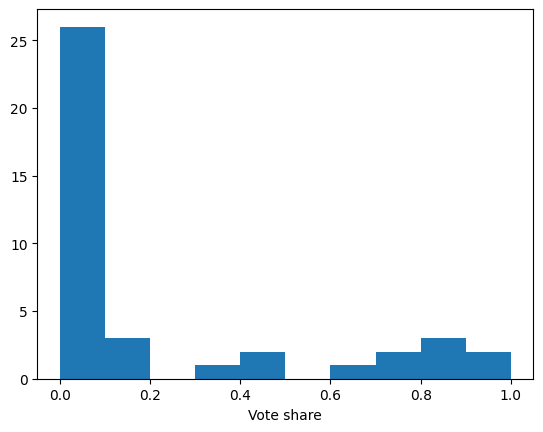

0.22359027253909053


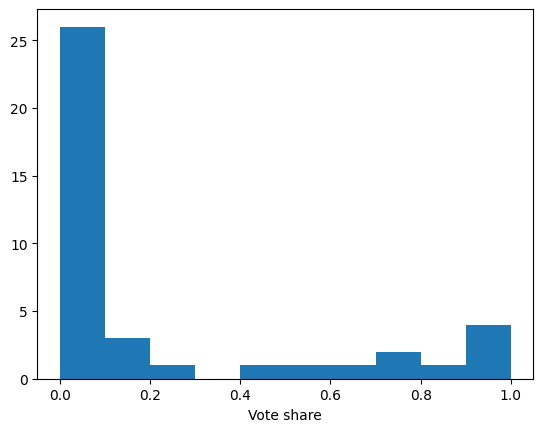

0.19067311480298227


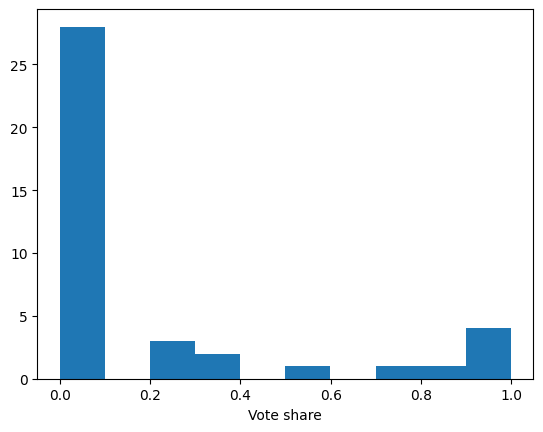

0.36207901580979057


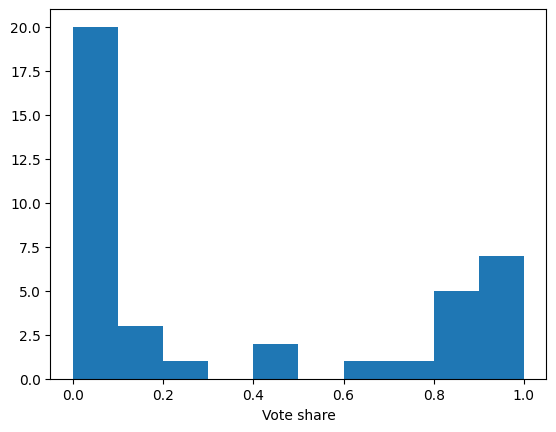

In [224]:
for i in [0,1,2,3]:
    mean_share = prior_pred['likelihood'][2][:,i].mean()
    print(mean_share)

    fig, ax = plt.subplots()  
    ax.hist(prior_pred['likelihood'][2][:,i]) 
    plt.xlabel("Vote share")  
    plt.ylabel("")   
    plt.show()  

In [166]:
struct_df[dep].columns[0]

'cc_share'

In [217]:
post_pred['likelihood'][1,:,3]

array([1.54014384e-04, 1.19678988e-01, 1.43684842e-01, 2.96407565e-01,
       6.52187062e-03, 6.59943739e-03, 4.80486254e-01, 1.08375556e-03,
       2.22935310e-01, 3.25032080e-02, 1.18012263e-01, 3.27341268e-01,
       1.35599104e-02, 1.57014656e-01, 9.77573028e-02, 4.34775963e-02,
       2.84708031e-03, 7.88147586e-02, 1.53007224e-01, 5.26276642e-02,
       1.17452546e-01, 9.14607932e-02, 3.94351571e-02, 3.63240509e-01,
       2.56919340e-02, 3.24535180e-01, 3.98680318e-02, 9.76482580e-02,
       7.19654309e-03, 3.67150188e-02, 1.10529875e-01, 1.14249616e-01,
       1.47041924e-01, 1.52350834e-04, 5.94327405e-02, 4.70332338e-02,
       3.26350001e-04, 5.57998327e-02, 1.56887355e-01, 8.43597536e-02])

Posterior Predictive vote share for cc_share: 0.22
Observed vote share for cc_share: 0.28


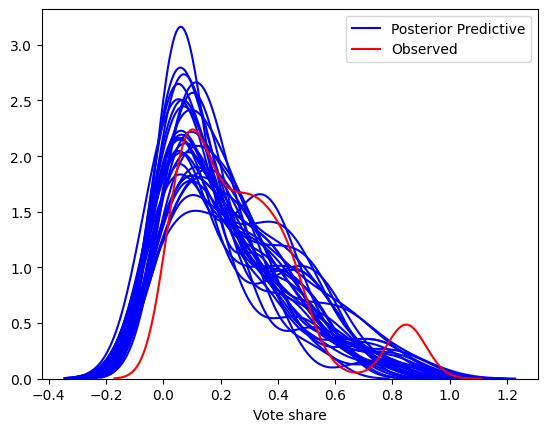

Posterior Predictive vote share for cc_share: 0.3
Observed vote share for cc_share: 0.27


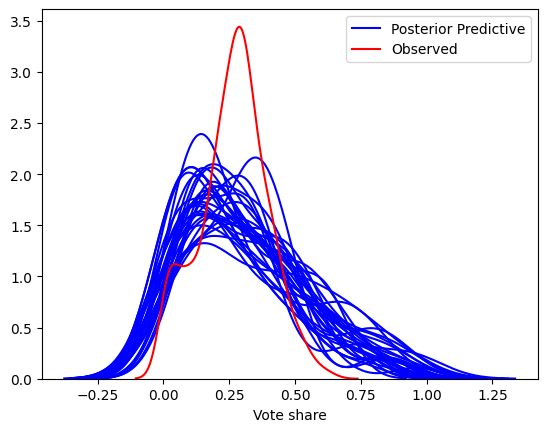

Posterior Predictive vote share for cc_share: 0.32
Observed vote share for cc_share: 0.37


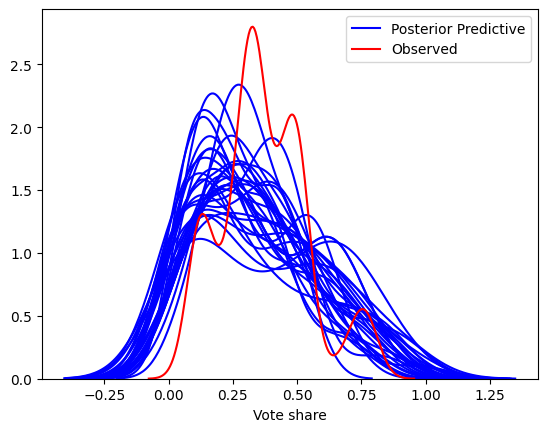

Posterior Predictive vote share for cc_share: 0.16
Observed vote share for cc_share: 0.08


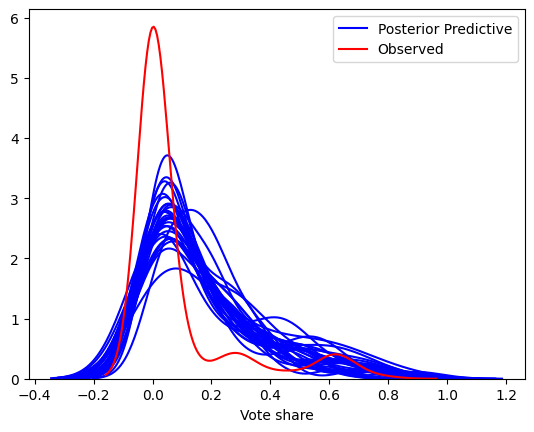

In [225]:
for i in [0,1,2,3]:
    pred_mean_share = round(np.mean(np.mean(post_pred['likelihood'], axis=0), axis=0)[i], 2)#post_pred['likelihood'][2][:,i].mean()
    actual_mean_share = round(struct_df[dep][struct_df[dep].columns[i]].mean(), 2)
    print(f"Posterior Predictive vote share for {struct_df[dep].columns[0]}: {pred_mean_share}")
    print(f"Observed vote share for {struct_df[dep].columns[0]}: {actual_mean_share}")

    fig, ax = plt.subplots()  
    for run in range(1,30):
        sns.kdeplot(post_pred['likelihood'][run,:,i], color='blue', ax=ax) 
    sns.kdeplot(post_pred['likelihood'][run,:,i], color='blue', label='Posterior Predictive', ax=ax) 
    sns.kdeplot(struct_df[dep][struct_df[dep].columns[i]], color='red', label='Observed', ax=ax) 
    ax.legend()
    plt.xlabel("Vote share")  
    plt.ylabel("")   
    plt.show()  


In [525]:
# polling data
# dataland_electoral_calendar.rename(columns={'election_cycle':'year'}, inplace=True)
polls_df = dataland_polls_1984_2023.merge(dataland_electoral_calendar, on=['year'], how='left')

# convert object to datetime
polls_df['date_conducted'] = pd.to_datetime(polls_df['date_conducted'])
polls_df['date_published'] = pd.to_datetime(polls_df['date_published'])

# create days to election col 
polls_df['election_day'] = pd.to_datetime(polls_df['election_day'])
polls_df['days_to_election'] = (polls_df['election_day'] - polls_df['date_published']).dt.days



In [270]:
# ~2% of polls are published the same day as election
(polls_df['days_to_election'] == 0).mean()

0.0225140712945591

<Axes: xlabel='days_to_election', ylabel='Count'>

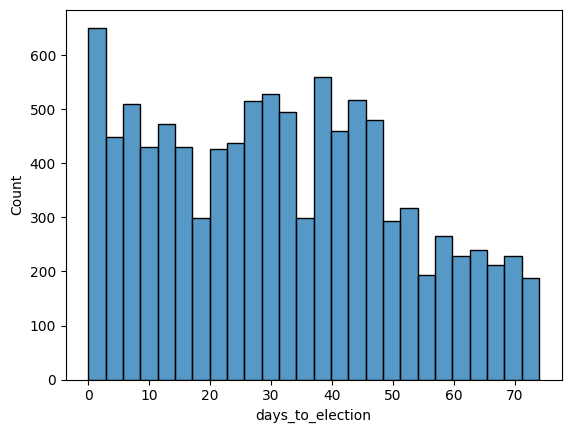

In [271]:
sns.histplot(polls_df, x='days_to_election')

In [289]:
prov_list = struct_df.province.unique().tolist()
region_list = struct_df.region.unique().tolist()
geo_list = polls_df.geography.unique().tolist()

print([item for item in geo_list if item not in prov_list+region_list])
# print([item for item in geo_list if item not in region_list])

['National']


In [288]:
# if region poll exists

array(['Amperville', 'Binaryshire', 'Byteforge Domain', 'Cerebrica',
       'Circuiton', 'Cortexia', 'Electropolis', 'Infinitron Peninsula',
       'Infoglen', 'Neuronia', 'Quantumridge', 'Voltagea'], dtype=object)

In [290]:
polls_df

,year,date_conducted,date_published,pollster,geography,mode,sample_size,population_surveyed,sponsor,cc_poll_share,...,dgm_conference_start_date,dgm_conference_end_date,pdal_conference_start_date,pdal_conference_end_date,ssp_conference_start_date,ssp_conference_end_date,debate_date_1,debate_date_2,debate_date_3,days_to_election
0,1984,1984-04-03,1984-04-04,Dataland Daily,National,Online,200,Adults,NaN,0.125,...,1984-05-12,1984-05-14,1984-05-05,1984-05-07,1984-04-21,1984-04-23,1984-05-18,1984-05-28,1984-06-07,74
1,1984,1984-04-05,1984-04-06,No Province Left Behind,Infinitron Peninsula,IVR,500,RV,NaN,0.418,...,1984-05-12,1984-05-14,1984-05-05,1984-05-07,1984-04-21,1984-04-23,1984-05-18,1984-05-28,1984-06-07,72
2,1984,1984-04-05,1984-04-06,Dataland Daily,National,Online,200,Adults,NaN,0.235,...,1984-05-12,1984-05-14,1984-05-05,1984-05-07,1984-04-21,1984-04-23,1984-05-18,1984-05-28,1984-06-07,72
3,1984,1984-04-04,1984-04-06,Dataland Daily,National,Online,200,Adults,NaN,0.180,...,1984-05-12,1984-05-14,1984-05-05,1984-05-07,1984-04-21,1984-04-23,1984-05-18,1984-05-28,1984-06-07,72
4,1984,1984-04-06,1984-04-07,Dataland Daily,National,Online,200,Adults,NaN,0.205,...,1984-05-12,1984-05-14,1984-05-05,1984-05-07,1984-04-21,1984-04-23,1984-05-18,1984-05-28,1984-06-07,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,2023,2023-06-16,2023-06-18,Metaflux University,Infinitron Peninsula,IVR,1500,RV,NaN,0.417,...,2023-05-13,2023-05-15,2023-05-06,2023-05-08,2023-04-22,2023-04-24,2023-05-19,2023-05-29,2023-06-08,0
10123,2023,2023-06-16,2023-06-18,Dataland Register-Gazette,National,Live caller,1500,LV,NaN,0.199,...,2023-05-13,2023-05-15,2023-05-06,2023-05-08,2023-04-22,2023-04-24,2023-05-19,2023-05-29,2023-06-08,0
10124,2023,2023-06-16,2023-06-18,Big Dataland Surveys,National,Online,10000,RV,NaN,0.169,...,2023-05-13,2023-05-15,2023-05-06,2023-05-08,2023-04-22,2023-04-24,2023-05-19,2023-05-29,2023-06-08,0
10125,2023,2023-06-16,2023-06-18,Synapse Strategies,Neuronia,Online,1000,LV,NaN,0.024,...,2023-05-13,2023-05-15,2023-05-06,2023-05-08,2023-04-22,2023-04-24,2023-05-19,2023-05-29,2023-06-08,0


In [275]:

polls_df.groupby('geography').date_published.count()

geography
Amperville                230
Binaryshire               368
Byteforge Domain          495
Cerebrica                 503
Circuit Confederation     523
Circuiton                 348
Cortexia                  491
Electropolis              509
Infinitron Peninsula      358
Infoglen                  458
Metaflux Realm            644
National                 3518
Neuronia                  326
Quantumridge              347
Synapse Territories       686
Voltagea                  323
Name: date_published, dtype: int64

In [296]:
polls_df.groupby('date_published').date_published.count().agg({'min', 'max', 'mean'})

mean     3.522435
min      1.000000
max     11.000000
Name: date_published, dtype: float64

In [299]:
polls_df.groupby('pollster').date_published.count()

pollster
Big Dataland Surveys             587
Cobolite Coalition Calling       795
Conference Board of Dataland     400
Dataland Daily                  2960
Dataland Register-Gazette       1351
Electropolis Elects              160
Metaflux University              782
No Province Left Behind          476
Progressive Polling              590
Proudly Paid For Polling        1552
Synapse Strategies               474
Name: date_published, dtype: int64

In [519]:
poll_shares = ['cc_poll_share', 'dgm_poll_share', 'pdal_poll_share', 'ssp_poll_share']
id_vars = polls_df.drop(poll_shares, axis=1).columns

polls_df_long = polls_df.melt(id_vars=id_vars,
                              var_name = 'party',
                              value_name = 'poll_share'
                              )

In [520]:
polls_df_long.poll_share.describe()

count    40508.000000
mean         0.222249
std          0.151852
min          0.000000
25%          0.090000
50%          0.230000
75%          0.318000
max          0.884000
Name: poll_share, dtype: float64

In [521]:
polls_df_long.columns

Index(['year', 'date_conducted', 'date_published', 'pollster', 'geography',
       'mode', 'sample_size', 'population_surveyed', 'sponsor',
       'undecided_poll_share', 'party', 'poll_share'],
      dtype='object')

In [351]:
# def weighted_average_by_day(df, party_col, value_column, sample_size_col):
#     # Convert columns to numeric if needed
#     df[value_column] = pd.to_numeric(df[value_column], errors='coerce')
#     df[sample_size_col] = pd.to_numeric(df[sample_size_col], errors='coerce')
    
#     # Calculate the weighted share for each row
#     df['weighted_share'] = df[value_column] * df[sample_size_col]

#     # Group the data by date and party and apply the weighted average function
#     result = df.groupby(['date_published', party_col]).apply(
#         lambda group: (group['weighted_share'] / group[sample_size_col].sum()).sum()
#     ).reset_index(name='weighted_avg')

#     # Replace 0s with NaNs
#     result['weighted_avg'] = result['weighted_avg'].replace(0, np.nan)

#     return result

# df_weighted = weighted_average_by_day(polls_df_long, 'party', 'poll_share', 'sample_size')


# weighted_polls_df = df_weighted.pivot(index='date_published', columns='party', values='weighted_avg').reset_index()
# weighted_polls_df.columns.name = None


In [352]:
# weighted_polls_df = weighted_polls_df.merge(polls_df[['year', 'date_published']], on=['date_published'], how='left').merge(dataland_electoral_calendar, on=['year'], how='left')
# weighted_polls_df['election_day'] = pd.to_datetime(weighted_polls_df['election_day'])

# # create days to election col 
# weighted_polls_df['days_to_election'] = (weighted_polls_df['election_day'] - weighted_polls_df['date_published']).dt.days

In [385]:
# # there are multiple geos per pollster, but only 1 poll per date per geo per pollster
# test = df.groupby(['pollster', 'geography', 'date_published']).date_published.count()
# test

pollster              geography              date_published
Big Dataland Surveys  Circuit Confederation  1984-06-03        1
                                             1984-06-12        1
                                             1985-04-29        1
                                             1985-05-02        1
                                             1985-05-31        1
                                                              ..
Synapse Strategies    Synapse Territories    2022-06-10        1
                                             2022-06-19        1
                                             2023-04-19        1
                                             2023-04-26        1
                                             2023-06-18        1
Name: date_published, Length: 9326, dtype: int64

In [386]:
polls_df[polls_df['geography'] == "Amperville"].groupby(['pollster', 'date_published']).date_published.count()

pollster                    date_published
Cobolite Coalition Calling  1984-04-08        1
                            1984-05-03        1
                            1985-04-10        1
                            1985-05-18        1
                            1986-04-11        1
                                             ..
Proudly Paid For Polling    2020-06-07        1
                            2022-05-05        1
                            2022-05-08        1
                            2022-06-09        1
                            2023-06-09        1
Name: date_published, Length: 229, dtype: int64

In [387]:
polls_df[polls_df['geography'] == "Amperville"].groupby(['pollster']).date_published.count()

pollster
Cobolite Coalition Calling    55
No Province Left Behind       80
Proudly Paid For Polling      95
Name: date_published, dtype: int64

In [390]:
polls_df[polls_df['geography'] == "Amperville"].date_published.count()

230

In [495]:
polls_df[polls_df['geography'] == "Amperville"].undecided_poll_share

6        0.190
40       0.120
67       0.144
110      0.075
161      0.076
         ...  
9930     0.064
9993     0.122
10048    0.076
10077    0.048
10089    0.036
Name: undecided_poll_share, Length: 226, dtype: float64

In [522]:
polls_df

,year,date_conducted,date_published,pollster,geography,mode,sample_size,population_surveyed,sponsor,cc_poll_share,dgm_poll_share,pdal_poll_share,ssp_poll_share,undecided_poll_share
0,1984,1984-04-03,1984-04-04,Dataland Daily,National,Online,200,Adults,NaN,0.125,0.270,0.375,0.035,0.195
1,1984,1984-04-05,1984-04-06,No Province Left Behind,Infinitron Peninsula,IVR,500,RV,NaN,0.418,0.262,0.200,0.000,0.120
2,1984,1984-04-05,1984-04-06,Dataland Daily,National,Online,200,Adults,NaN,0.235,0.240,0.295,0.060,0.170
3,1984,1984-04-04,1984-04-06,Dataland Daily,National,Online,200,Adults,NaN,0.180,0.265,0.320,0.035,0.200
4,1984,1984-04-06,1984-04-07,Dataland Daily,National,Online,200,Adults,NaN,0.205,0.195,0.320,0.050,0.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,2023,2023-06-16,2023-06-18,Metaflux University,Infinitron Peninsula,IVR,1500,RV,NaN,0.417,0.323,0.203,0.000,0.057
10123,2023,2023-06-16,2023-06-18,Dataland Register-Gazette,National,Live caller,1500,LV,NaN,0.199,0.301,0.413,0.063,0.024
10124,2023,2023-06-16,2023-06-18,Big Dataland Surveys,National,Online,10000,RV,NaN,0.169,0.327,0.394,0.052,0.058
10125,2023,2023-06-16,2023-06-18,Synapse Strategies,Neuronia,Online,1000,LV,NaN,0.024,0.198,0.104,0.619,0.055


In [526]:
# polls_df['sponsor'] = polls_df['sponsor'].fillna('None')
# consider only polls published before election day
polls_df = polls_df[polls_df['days_to_election'] != 0]

# drop undecided voters
polls_df = polls_df.drop(columns="undecided_poll_share", axis=1)

In [527]:
polls_df.columns

Index(['year', 'date_conducted', 'date_published', 'pollster', 'geography',
       'mode', 'sample_size', 'population_surveyed', 'sponsor',
       'cc_poll_share', 'dgm_poll_share', 'pdal_poll_share', 'ssp_poll_share',
       'election_day', 'cc_conference_start_date', 'cc_conference_end_date',
       'dgm_conference_start_date', 'dgm_conference_end_date',
       'pdal_conference_start_date', 'pdal_conference_end_date',
       'ssp_conference_start_date', 'ssp_conference_end_date', 'debate_date_1',
       'debate_date_2', 'debate_date_3', 'days_to_election'],
      dtype='object')

In [532]:
pd.get_dummies(df[indep_polls], columns=['mode', 'sponsor'])

,days_to_election,mode_IVR,mode_Online,sponsor_CC,sponsor_DGM,sponsor_PDAL
0,70,True,False,True,False,False
1,53,True,False,False,False,False
2,45,True,False,True,False,False
3,35,False,True,False,True,False
4,23,False,True,False,False,True
...,...,...,...,...,...,...
221,47,True,False,False,False,False
222,32,True,False,True,False,False
223,18,True,False,False,False,False
224,12,True,False,False,False,False


In [533]:
df = polls_df[polls_df['geography'] == "Amperville"].reset_index(drop=True)

indep_polls = ['days_to_election', 'mode', 'sponsor']
dep_polls = ['cc_poll_share', 'dgm_poll_share', 'pdal_poll_share', 'ssp_poll_share']
level = ['pollster'] # election year

df_indep_polls = pd.get_dummies(df[indep_polls], columns=['mode', 'sponsor']).astype(int).drop(columns=['mode_Online']) # drop first after fixcing the NA issue
min_value = polls_df['days_to_election'].min()
max_value = polls_df['days_to_election'].max()
df_indep_polls['days_to_election'] = (polls_df['days_to_election'] - min_value) / (max_value - min_value)
df_dep_polls =  df[dep_polls] + 0.001 # add 0.01 to account for 0s in the party vote shares; otherwise get -inf due to division by 0
# df_level =  df[level]

pollster_idx, pollster = df.pollster.factorize(sort=True)

coords_polls = {
    "dep": df_dep_polls.columns,
    "sample": np.arange(len(df_dep_polls)),
    "indep": df_indep_polls.columns,
    "pollster": pollster,
}

In [536]:
a.tag.test_value.shape

(226, 4)

In [535]:
with pm.Model(coords=coords_polls) as poll_model:
    # data inputs
    ivs = pm.Data('ivs', df_indep_polls.values, dims=('sample', 'indep')) # NxK
    dv = pm.Data('dv', df_dep_polls.values, dims=('sample', 'dep')) # Nx1

    # use posterior pred distribution from structural model as prior
    theta = pm.Dirichlet('theta', a=np.mean(np.mean(post_pred['likelihood'], axis=0), axis=0))
    # scaling factor to adjust probabilities
    # exptheta = pm.Deterministic('exptheta', pm.math.exp(theta))

    # hyperpriors
    # b0_mu = pm.Normal('b0_mu', 0, 1)
    # b0_mu = pm.HalfCauchy('b0_sigma', 1.0)

    # varying intercept by election year
    b0 = pm.Normal('b0', 0, 1, dims=('pollster', 'dep')) # Nx1

    b = pm.Normal('b', 0, 1, dims=('indep', 'dep')) # 1xK
    # sigma_b = pm.HalfNormal('sigma_b', 0.1, dims=('indep', 'dep'))#pm.Normal('sigma_b', 0, 1, dims=('indep'))

    # a = pm.Deterministic('a', pm.math.exp(b0+ pm.math.dot(ivs, b))) # results in Nx1
    a = pm.Deterministic('a', theta * pm.math.invlogit(b0[pollster_idx]+pm.math.dot(ivs, b))) # results in Nx1

    # Dirichlet likelihood to model the observed dependent variables
    lik = pm.Dirichlet('likelihood', a=a, observed=dv, dims=('sample', 'dep'))

    # # # perform inference using the data  
    trace_polls = pm.sample(draws=1000, tune=100, chains=2, random_seed=45)  

    # # # sampling data from before and after data is available  
    prior_pred_polls = pm.sample_prior_predictive()  
    post_pred_polls = pm.sample_posterior_predictive(trace_polls) 


/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, b0, theta]


/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.9117363796511564, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9195269860218164, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

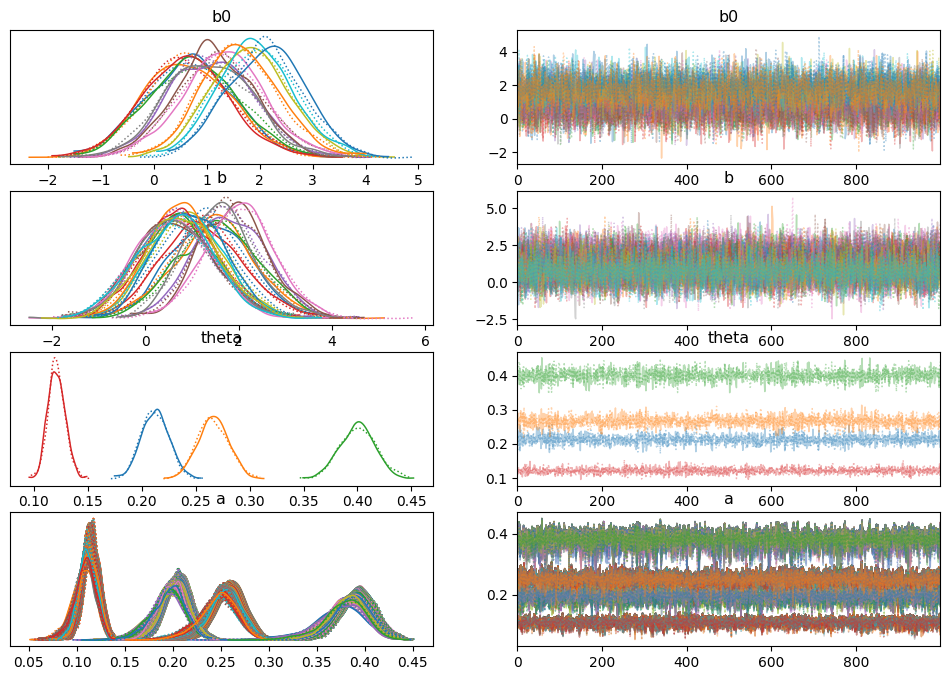

In [537]:
az.plot_trace(trace_polls)

In [489]:
az.summary(trace_polls)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/kbeebe/Desktop/economist_forecasting/election_forecaster/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"b0[Cobolite Coalition Calling, cc_poll_share]",0.707,0.877,-0.838,2.432,0.021,0.018,1756.0,1415.0,1.0
"b0[Cobolite Coalition Calling, dgm_poll_share]",0.712,0.805,-0.781,2.269,0.018,0.015,1914.0,1660.0,1.0
"b0[Cobolite Coalition Calling, pdal_poll_share]",0.783,0.875,-0.843,2.451,0.020,0.015,1947.0,1459.0,1.0
"b0[Cobolite Coalition Calling, ssp_poll_share]",0.658,0.879,-0.938,2.296,0.020,0.018,1907.0,1341.0,1.0
"b0[Cobolite Coalition Calling, undecided_poll_share]",0.723,0.840,-0.730,2.370,0.024,0.017,1270.0,1361.0,1.0
...,...,...,...,...,...,...,...,...,...
"a[225, 0]",0.166,0.014,0.139,0.191,0.000,0.000,2416.0,1557.0,1.0
"a[225, 1]",0.204,0.016,0.171,0.233,0.000,0.000,2108.0,1450.0,1.0
"a[225, 2]",0.289,0.019,0.255,0.324,0.000,0.000,2730.0,1975.0,1.0
"a[225, 3]",0.099,0.010,0.081,0.118,0.000,0.000,2012.0,1688.0,1.0


0.004424779353747952


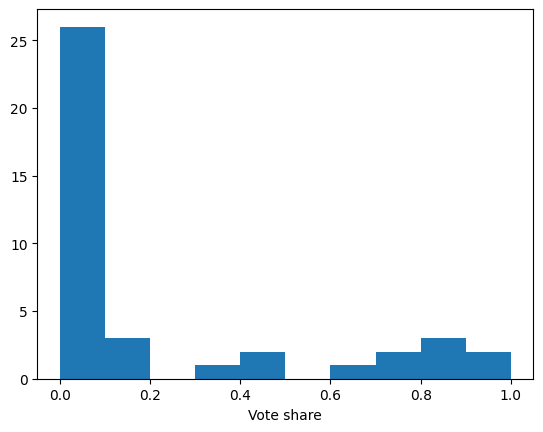

2.3536278921936962e-32


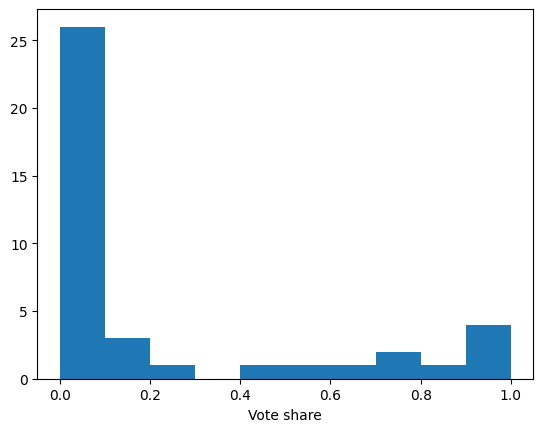

0.9580323783443722


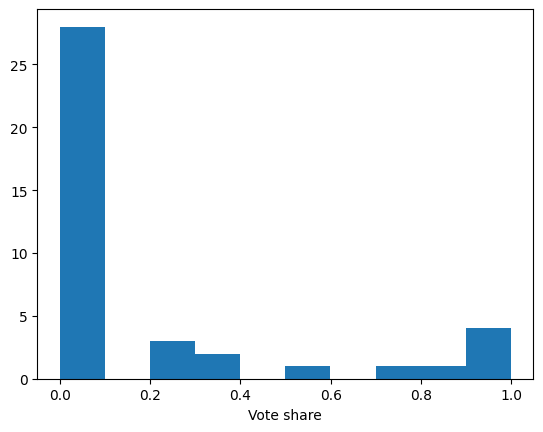

0.037542842301879875


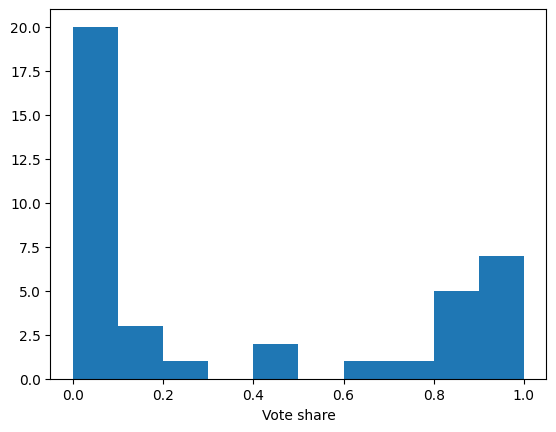

In [538]:
for i in [0,1,2,3]:
    mean_share = prior_pred_polls['likelihood'][2][:,i].mean()
    print(mean_share)

    fig, ax = plt.subplots()  
    ax.hist(prior_pred['likelihood'][2][:,i]) 
    plt.xlabel("Vote share")  
    plt.ylabel("")   
    plt.show()  

In [493]:
prior_pred_polls['likelihood'].shape

(500, 226, 5)

Posterior Predictive vote share for cc_share: 0.21
Observed vote share for cc_share: 0.28


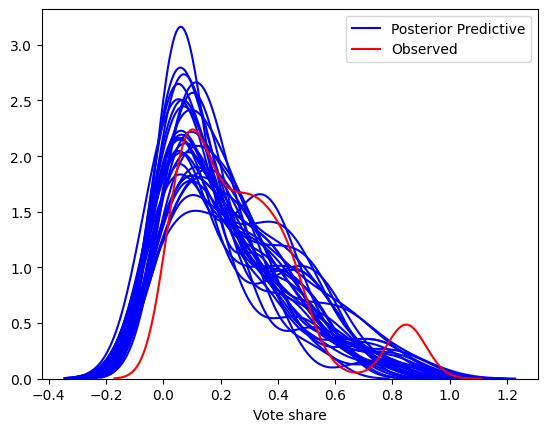

Posterior Predictive vote share for cc_share: 0.27
Observed vote share for cc_share: 0.27


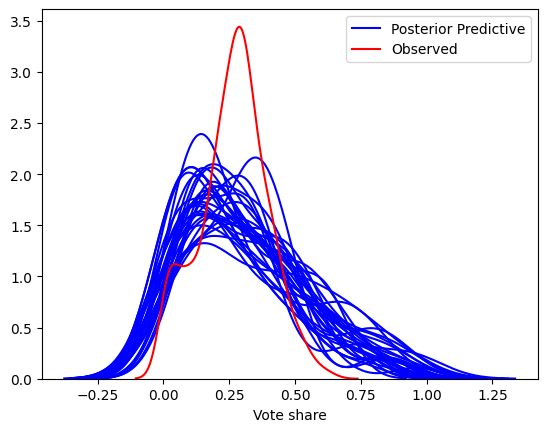

Posterior Predictive vote share for cc_share: 0.41
Observed vote share for cc_share: 0.37


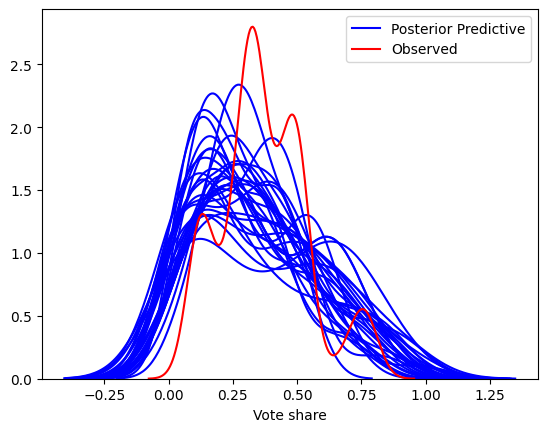

Posterior Predictive vote share for cc_share: 0.12
Observed vote share for cc_share: 0.08


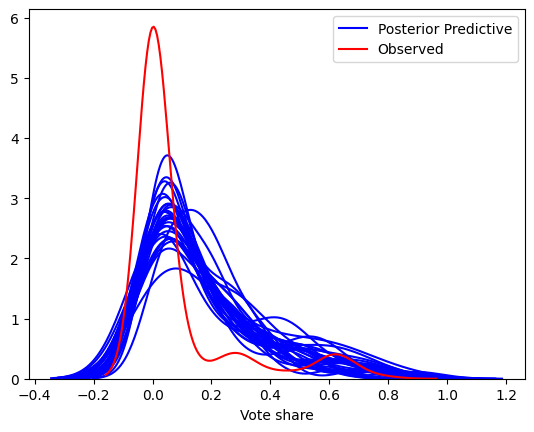

In [539]:
for i in [0,1,2,3]:
    pred_mean_share = round(np.mean(np.mean(post_pred_polls['likelihood'], axis=0), axis=0)[i], 2)#post_pred['likelihood'][2][:,i].mean()
    actual_mean_share = round(struct_df[dep][struct_df[dep].columns[i]].mean(), 2)
    print(f"Posterior Predictive vote share for {struct_df[dep].columns[0]}: {pred_mean_share}")
    print(f"Observed vote share for {struct_df[dep].columns[0]}: {actual_mean_share}")

    fig, ax = plt.subplots()  
    for run in range(1,30):
        sns.kdeplot(post_pred['likelihood'][run,:,i], color='blue', ax=ax) 
    sns.kdeplot(post_pred['likelihood'][run,:,i], color='blue', label='Posterior Predictive', ax=ax) 
    sns.kdeplot(struct_df[dep][struct_df[dep].columns[i]], color='red', label='Observed', ax=ax) 
    ax.legend()
    plt.xlabel("Vote share")  
    plt.ylabel("")   
    plt.show()  

In [506]:
post_pred_polls['likelihood'][1,6,:]

array([1.15936087e-03, 3.22348934e-01, 6.61225846e-01, 1.52253819e-02,
       4.04769841e-05])

In [508]:
struct_df[struct_df['province'] == "Amperville"]

,year,province,region,party_in_power,provincial_winner,national_winner,national_pop_vote_winner,cc_share,dgm_share,pdal_share,ssp_share,population,python_pop_share,cobolite_pop_share,javarian_pop_share,electoral_college_votes,year_on_year_gdp_pct_change,unemployment_rate,year_on_year_inflation,year_on_year_stock_mkt_pct_change
0,1984,Amperville,Circuit Confederation,pdal,pdal,pdal,pdal,0.047924,0.181743,0.770333,0.0,1000000,0.765173,0.084048,0.15078,15,0.03600,0.04800,0.06150,0.20275
12,1985,Amperville,Circuit Confederation,pdal,pdal,pdal,pdal,0.048893,0.190777,0.760330,0.0,1000000,0.765173,0.084048,0.15078,15,0.02025,0.04200,0.15400,0.11625
24,1986,Amperville,Circuit Confederation,pdal,pdal,cc,cc,0.148951,0.087597,0.763452,0.0,1000000,0.765173,0.084048,0.15078,15,0.00025,0.04175,0.13150,0.22550
36,1987,Amperville,Circuit Confederation,cc,pdal,pdal,pdal,0.030492,0.214624,0.754884,0.0,1000000,0.765173,0.084048,0.15078,15,-0.01450,0.04450,0.15925,-0.00575
48,1988,Amperville,Circuit Confederation,pdal,pdal,pdal,pdal,0.085023,0.188648,0.726330,0.0,1000000,0.765173,0.084048,0.15078,15,0.01650,0.06325,0.06400,-0.11800
60,1989,Amperville,Circuit Confederation,pdal,pdal,dgm,pdal,0.052424,0.248051,0.699525,0.0,1000000,0.765173,0.084048,0.15078,15,0.01550,0.07350,0.05700,0.02275
72,1990,Amperville,Circuit Confederation,dgm,pdal,pdal,pdal,0.057297,0.167722,0.774981,0.0,1000000,0.765173,0.084048,0.15078,15,0.01050,0.08625,0.06125,-0.08275
84,1991,Amperville,Circuit Confederation,pdal,pdal,cc,pdal,0.065670,0.239913,0.694417,0.0,1000000,0.765173,0.084048,0.15078,15,-0.02250,0.10925,0.02625,-0.01375
96,1992,Amperville,Circuit Confederation,cc,pdal,dgm,pdal,0.061042,0.197968,0.740990,0.0,1000000,0.765173,0.084048,0.15078,15,0.01050,0.10450,0.01025,0.04300
108,1993,Amperville,Circuit Confederation,dgm,pdal,pdal,pdal,0.052420,0.219228,0.728352,0.0,1000000,0.765173,0.084048,0.15078,15,0.04775,0.09600,0.01300,0.10150
